In [1]:
#mixup.py
import math
import random

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from keras import backend as K
from keras.models import Model
from keras.regularizers import l2
from keras.utils import to_categorical
from keras.datasets import mnist, cifar10
from keras.layers import Activation, Input, Dense, Conv2D, LeakyReLU
from keras.layers import Dropout, BatchNormalization, Flatten, Reshape, SpatialDropout2D

Using TensorFlow backend.


In [2]:
def _mixup_batch(in_batch: np.ndarray, out_batch: np.ndarray, alpha: int = 1.0):
    """Mixup the batch by sampling from a beta distribution and 
    computing a weighted average of the first half of the batch with last half."""
    half = in_batch.shape[0] // 2
    mixed_ins = np.zeros((half,) + in_batch.shape[1:])
    mixed_outs = np.zeros((half,) + out_batch.shape[1:])
    for i in range(half):
        weight0 = np.random.beta(alpha, alpha)
        weight1 = 1 - weight0
        mixed_ins[i] = (in_batch[i, ...] * weight0) + (in_batch[half+i, ...] * weight1)
        mixed_outs[i] = (out_batch[i, ...] * weight0) + (out_batch[half+i, ...] * weight1)

    return mixed_ins, mixed_outs

In [3]:
def load_mnist():
    img_rows, img_cols = 28, 28

    # the data, shuffled and split between train and test sets
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1).astype('float32')
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1).astype('float32')
    x_train /= 128.0
    x_test /= 128.0
    x_train -= 1.0
    x_test -= 1.0
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)
    print('bounds:', np.min(x_train), np.max(x_train))
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    print('y_train shape:', y_train.shape)
    print('y_train sum:', np.sum(y_train, axis=0))
    return (x_train, y_train), (x_test, y_test)

In [4]:
def load_cifar():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255.0
    x_test /= 255.0
    #x_train -= 1.0
    #x_test -= 1.0
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)
    print('bounds:', np.min(x_train), np.max(x_train))
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')	
    return (x_train, y_train), (x_test, y_test)

In [5]:
def _plot_batch(image_batch):
    batch_size = image_batch.shape[0]
    sqrt_batch = int(math.sqrt(batch_size))
    _, axes = plt.subplots(sqrt_batch, sqrt_batch, figsize=(18, 14))
    for i in range(batch_size):
        if image_batch.shape[-1] == 1:
            axes[i//sqrt_batch, i%sqrt_batch].imshow(image_batch[i, :, :, 0])
        else:
            axes[i//sqrt_batch, i%sqrt_batch].imshow(image_batch[i, ...])

In [6]:
def build_discriminative_model(in_shape, out_classes):
    d_input = Input(in_shape)
    H = Conv2D(128, (3, 3), strides=(2,2), padding='same', kernel_regularizer=l2(0.001))(d_input)
    H = BatchNormalization(momentum=0.9)(H)
    H = LeakyReLU(0.2)(H)
    H = Conv2D(64, (3, 3), strides=(2,2), padding='same', kernel_regularizer=l2(0.001))(H)
    H = BatchNormalization(momentum=0.9)(H)
    H = LeakyReLU(0.2)(H)
    H = Flatten()(H)
    H = Dense(32, kernel_regularizer=l2(0.001))(H)
    H = BatchNormalization(momentum=0.9)(H)
    d_V = Dense(out_classes, activation='softmax', kernel_regularizer=l2(0.001))(H)
    discriminator = Model(d_input, d_V)
    discriminator.compile(loss='categorical_crossentropy', optimizer='adam')
    discriminator.summary()
    return discriminator

mnist_discriminator = build_discriminative_model((28, 28, 1), 10)
cifar_discriminator = build_discriminative_model((32, 32, 3), 10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       1280      
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          73792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0         
__________

In [7]:
def _accuracy_on_batch(discriminator, batch, y):
    y_hat = discriminator.predict(batch)
    y_hat_idx = np.argmax(y_hat, axis=-1)
    y_idx = np.argmax(y, axis=-1)
    diff = y_idx-y_hat_idx
    n_tot = y.shape[0]
    n_rig = (diff==0).sum()
    acc = n_rig*100.0/n_tot
    print(f'y true sum:{[f"{num:0.1f}" for num in np.sum(y, axis=0)]}. Accuracy: {acc:0.02f} pct ({n_rig} of {n_tot}).')
    print(f'y pred sum:{[f"{num:0.1f}" for num in np.sum(y_hat, axis=0)]}')

bounds: -1.0 0.9921875
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
y_train shape: (60000, 10)
y_train sum: [5923. 6742. 5958. 6131. 5842. 5421. 5918. 6265. 5851. 5949.]
y true sum:['6.0', '11.0', '6.0', '4.0', '6.0', '4.0', '3.0', '9.0', '5.0', '10.0']. Accuracy: 59.38 pct (38 of 64).
y pred sum:['6.8', '5.6', '7.7', '9.7', '8.2', '5.1', '3.7', '3.7', '7.3', '6.2']
step 0 with loss 3.2212748527526855
y true sum:['5.0', '4.0', '5.0', '7.0', '5.0', '7.0', '7.0', '13.0', '4.0', '7.0']. Accuracy: 73.44 pct (47 of 64).
y pred sum:['4.7', '4.8', '6.8', '6.5', '10.0', '3.8', '6.2', '7.5', '7.1', '6.6']
step 5 with loss 1.0873603820800781


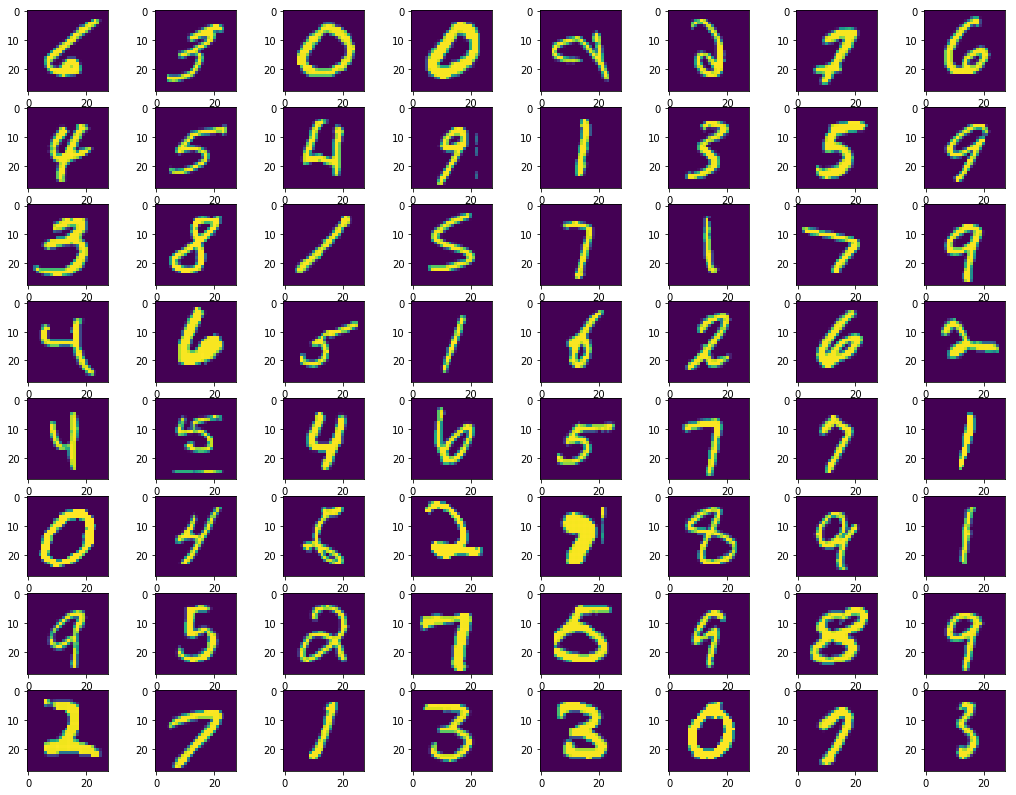

In [8]:
def _train_on_batches(discriminator, x_train, y_train, steps, batch_size, mixup=False, alpha=1.0, steps_per_print=5):
    if mixup:
        batch_size *= 2
    for s in range(steps):
        indexes = np.random.randint(0, x_train.shape[0], size=batch_size)
        image_batch = x_train[indexes, ...] 
        class_label = y_train[indexes, ...]
        if mixup:
            image_batch, class_label = _mixup_batch(image_batch, class_label, alpha)
        d_loss = discriminator.train_on_batch(image_batch, class_label)
        if s%steps_per_print == 0:
            _accuracy_on_batch(discriminator, image_batch, class_label)
            print(f'step {s} with loss {d_loss}')
    _plot_batch(image_batch)
            
(mnist_x, mnist_y), _ = load_mnist()            
_train_on_batches(mnist_discriminator, mnist_x, mnist_y, 10, 64, mixup=False)

y true sum:['7.7', '7.7', '5.6', '4.7', '9.9', '7.7', '5.7', '7.1', '2.8', '5.1']. Accuracy: 53.12 pct (34 of 64).
y pred sum:['7.8', '6.8', '2.8', '8.6', '7.0', '3.1', '9.0', '4.5', '6.1', '8.2']
step 0 with loss 1.650383472442627
y true sum:['3.7', '10.4', '5.0', '9.0', '4.2', '6.1', '7.8', '5.7', '6.9', '5.2']. Accuracy: 75.00 pct (48 of 64).
y pred sum:['2.8', '8.4', '5.0', '9.9', '3.4', '3.3', '6.9', '4.6', '12.4', '7.1']
step 5 with loss 1.684694528579712


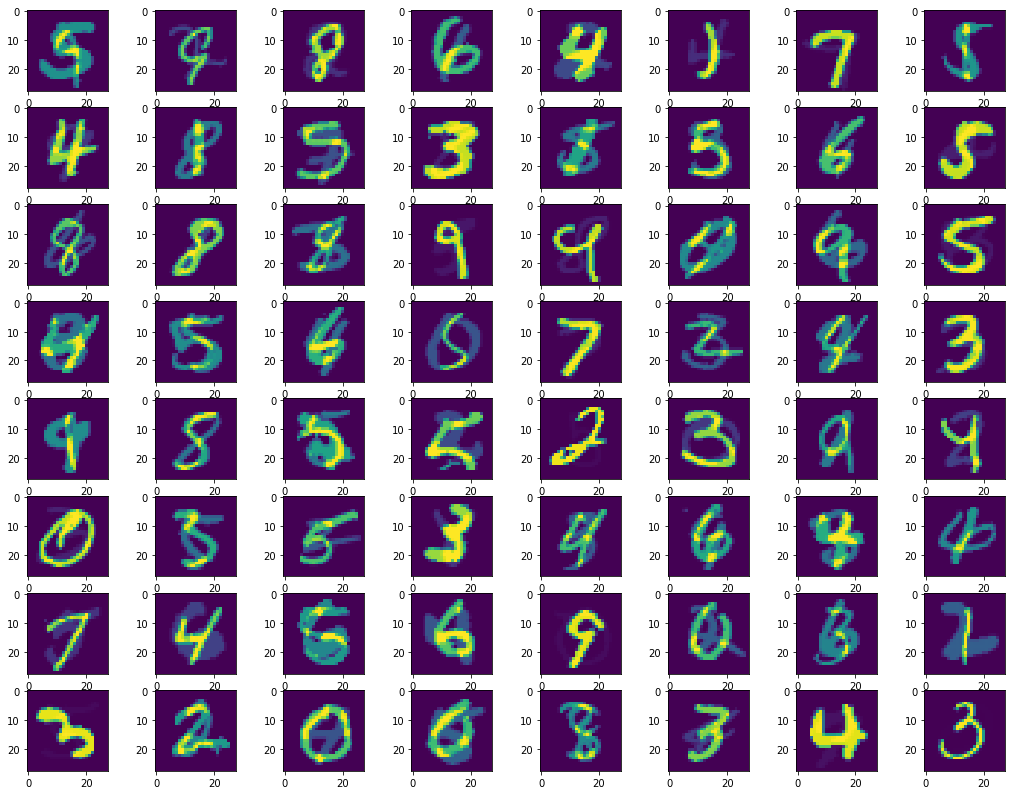

In [9]:
_train_on_batches(mnist_discriminator, mnist_x, mnist_y, 10, 64, mixup=True)

y true sum:[5, 7, 6, 3, 8, 9, 9, 3, 6, 4]. Accuracy: 73.44 pct (47 of 64).
y pred sum:[6, 7, 4, 6, 11, 4, 8, 4, 5, 4]
step 0 with loss 1.239593744277954
y true sum:[6, 5, 3, 4, 10, 6, 7, 8, 6, 3]. Accuracy: 79.69 pct (51 of 64).
y pred sum:[6, 7, 3, 4, 10, 5, 6, 7, 7, 5]
step 5 with loss 1.254333734512329


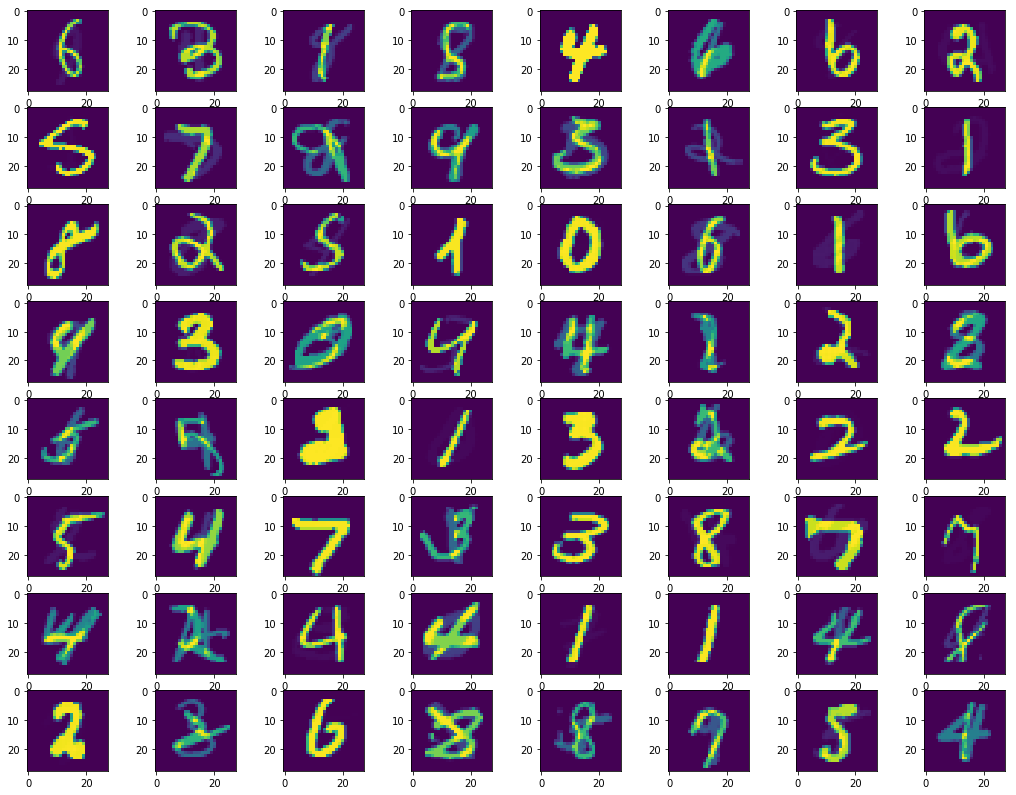

In [11]:
_train_on_batches(mnist_discriminator, mnist_x, mnist_y, 10, 64, mixup=True, alpha=0.5)

y true sum:[6, 4, 5, 7, 4, 6, 2, 9, 7, 9]. Accuracy: 64.06 pct (41 of 64).
y pred sum:[6, 5, 6, 5, 6, 3, 5, 10, 6, 8]
step 0 with loss 1.617085337638855
y true sum:[6, 8, 5, 9, 2, 3, 6, 8, 6, 6]. Accuracy: 60.94 pct (39 of 64).
y pred sum:[6, 8, 5, 9, 3, 3, 8, 8, 6, 4]
step 5 with loss 1.6268808841705322


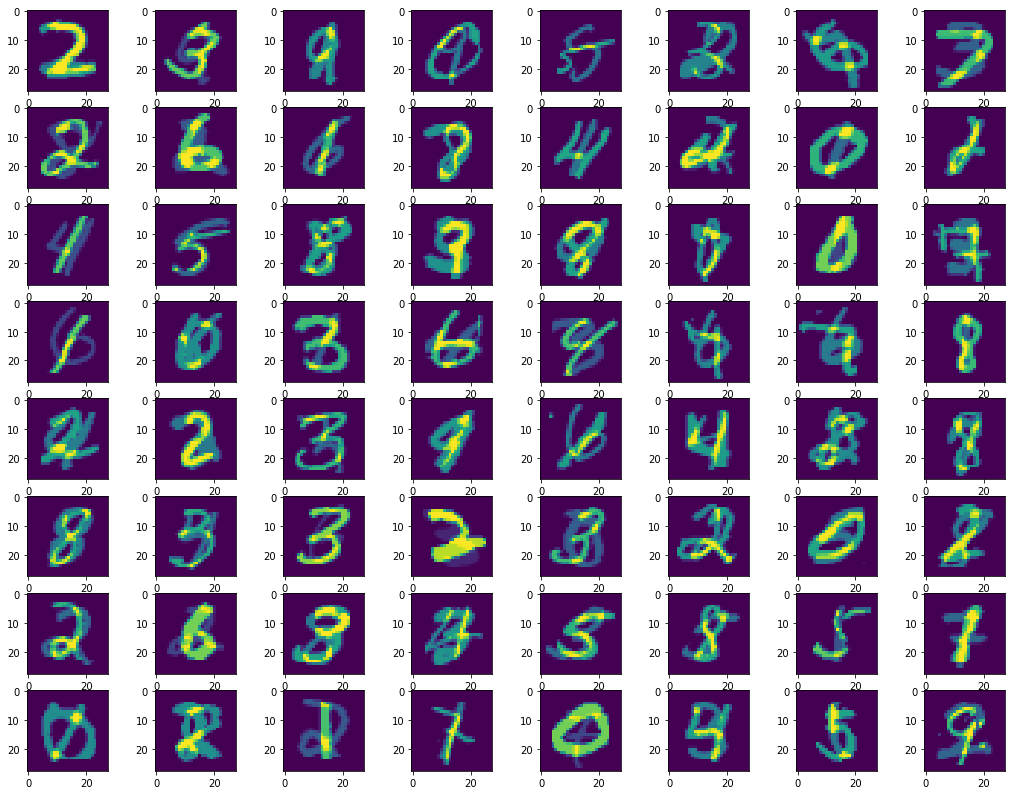

In [12]:
_train_on_batches(mnist_discriminator, mnist_x, mnist_y, 10, 64, mixup=True, alpha=5.0)

y true sum:[6, 9, 3, 3, 4, 7, 10, 7, 4, 7]. Accuracy: 54.69 pct (35 of 64).
y pred sum:[6, 8, 4, 5, 5, 5, 9, 8, 5, 6]
step 0 with loss 1.4655336141586304
y true sum:[6, 7, 6, 5, 6, 3, 5, 7, 6, 9]. Accuracy: 51.56 pct (33 of 64).
y pred sum:[7, 7, 8, 6, 6, 4, 4, 8, 7, 4]
step 5 with loss 1.4959436655044556


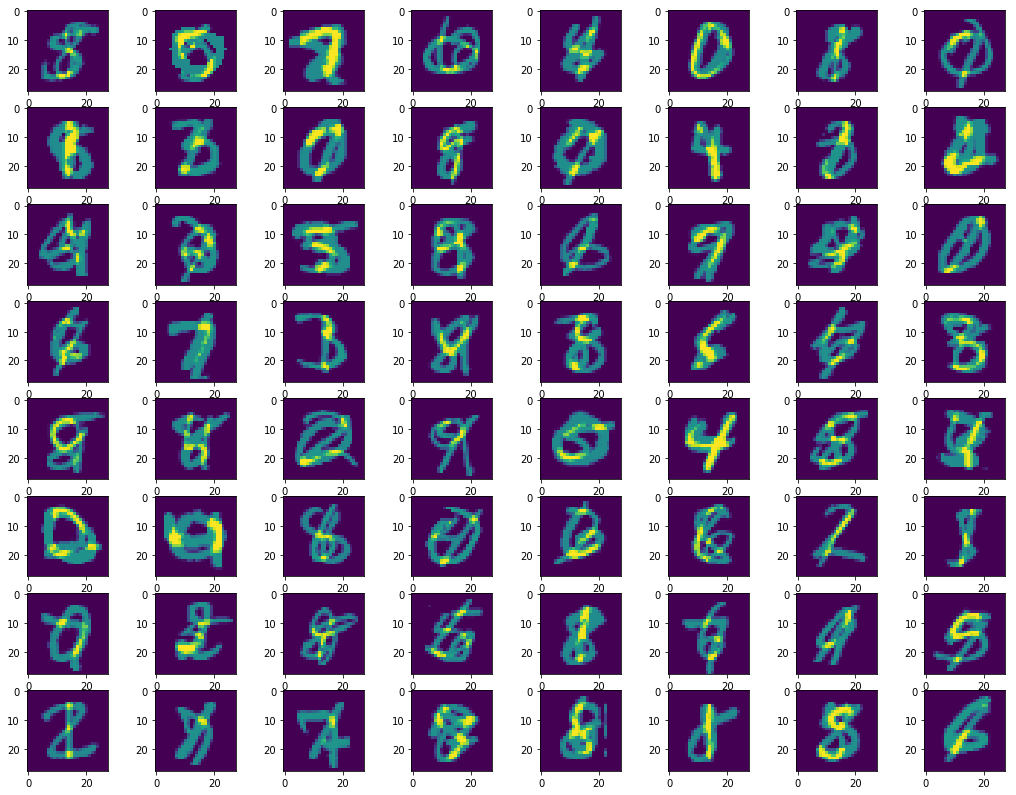

In [13]:
_train_on_batches(mnist_discriminator, mnist_x, mnist_y, 10, 64, mixup=True, alpha=500.0)

170500096/170498071 [==============================] - 2s 0us/step
bounds: 0.0 1.0
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y true sum:[13, 11, 4, 11, 15, 7, 7, 12, 12, 8]. Accuracy: 45.00 pct (45 of 100).
y pred sum:[19, 19, 9, 3, 6, 6, 5, 9, 10, 8]
step 0 with loss 2.988926887512207
y true sum:[10, 7, 12, 8, 16, 9, 9, 9, 9, 11]. Accuracy: 24.00 pct (24 of 100).
y pred sum:[9, 15, 2, 12, 7, 9, 6, 10, 13, 11]
step 5 with loss 2.4556386470794678


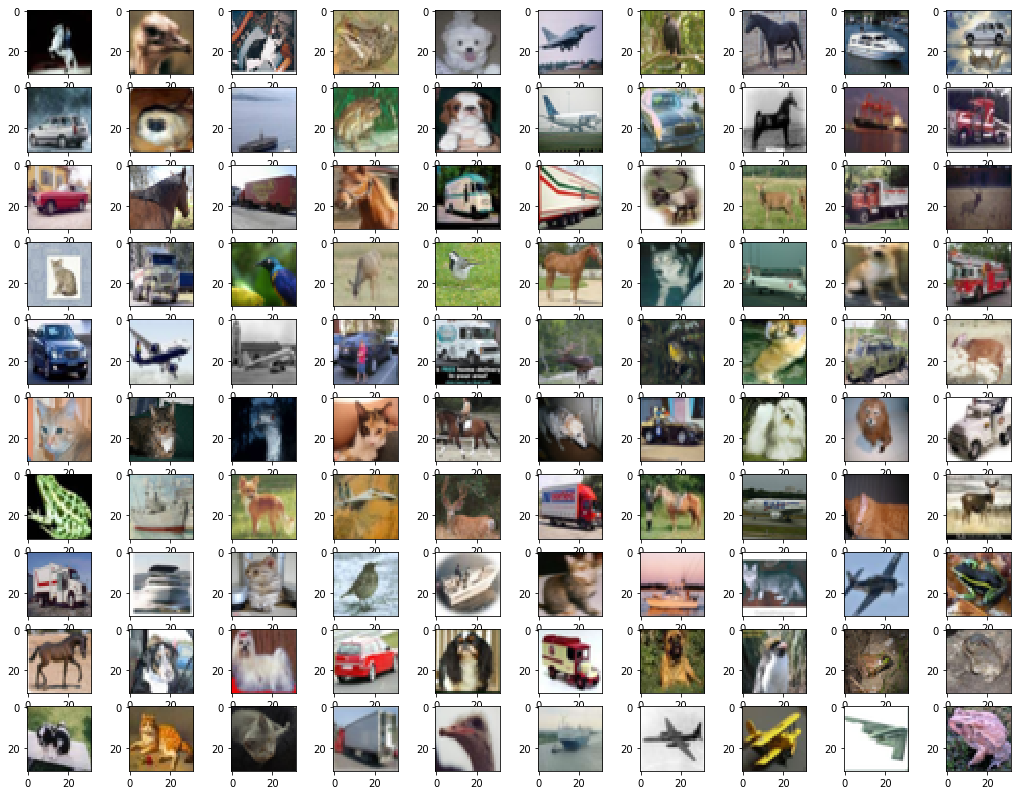

In [14]:
(cifar_x, cifar_y), _ = load_cifar()            
_train_on_batches(cifar_discriminator, cifar_x, cifar_y, 10, 100, mixup=False)

y true sum:[0, 1, 1, 1, 1, 1, 3, 1, 2, 0]. Accuracy: 18.75 pct (3 of 16).
y pred sum:[2, 2, 0, 1, 0, 1, 1, 1, 1, 2]
step 0 with loss 2.2428057193756104


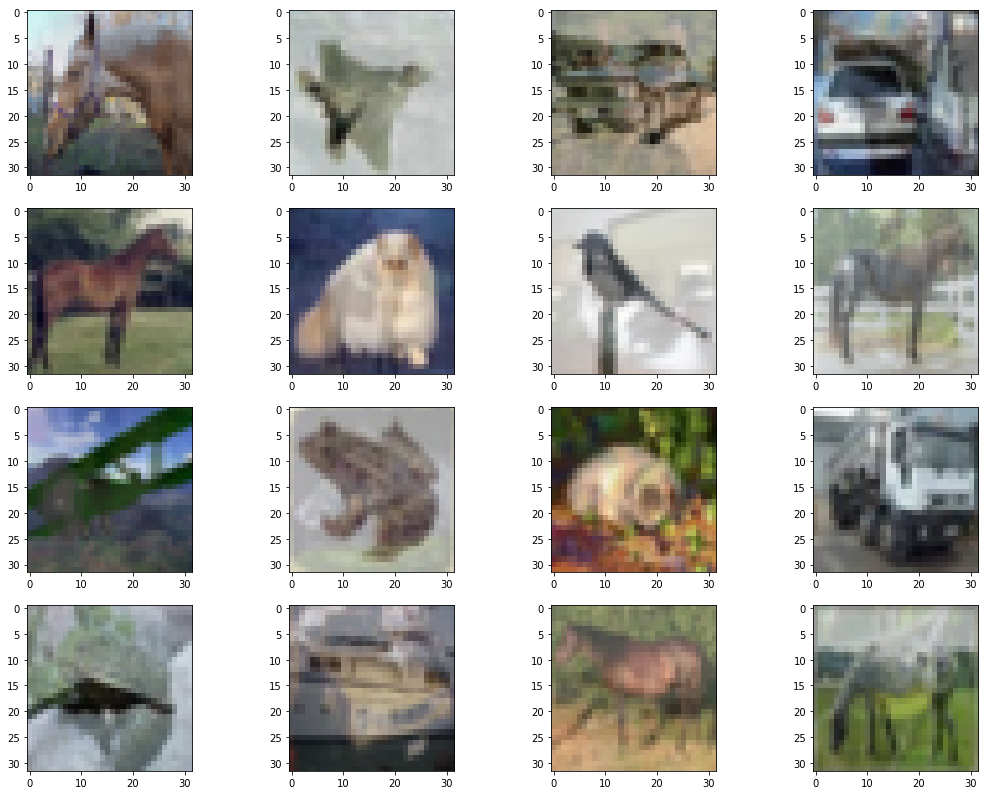

In [15]:
_train_on_batches(cifar_discriminator, cifar_x, cifar_y, 5, 16, mixup=True)

y true sum:[21, 19, 19, 23, 23, 20, 22, 27, 24, 21]. Accuracy: 19.56 pct (44 of 225).
y pred sum:[33, 45, 7, 28, 9, 25, 18, 14, 21, 21]
step 0 with loss 2.438917875289917


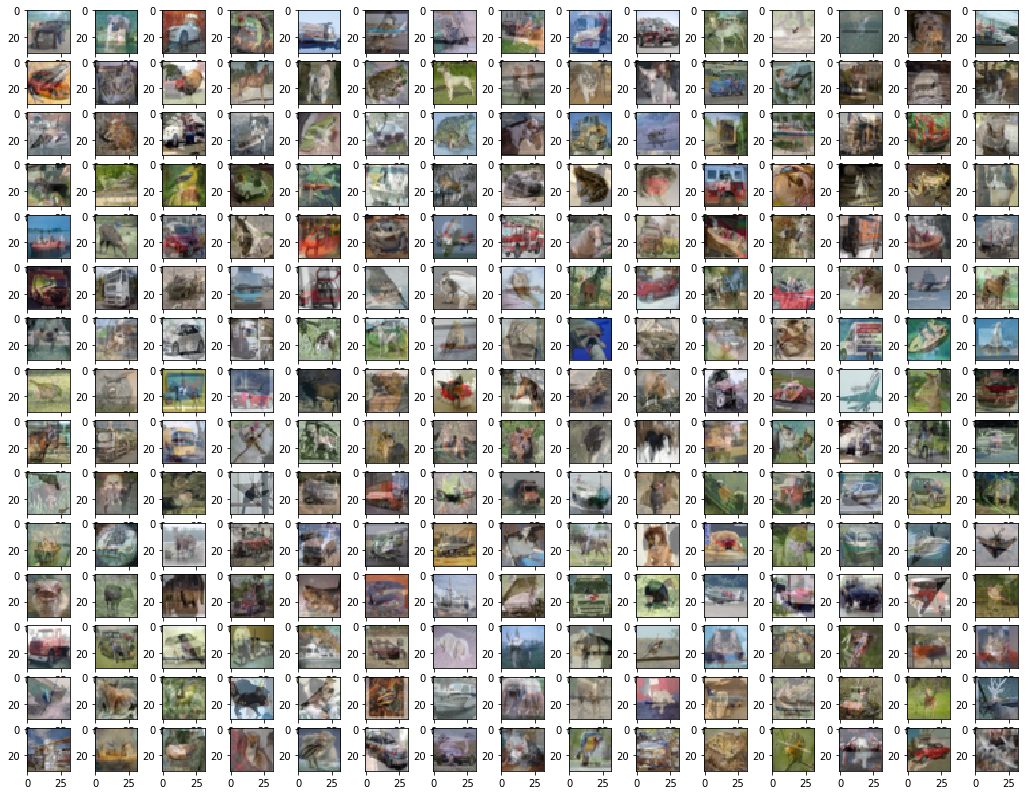

In [16]:
_train_on_batches(cifar_discriminator, cifar_x, cifar_y, 5, 225, mixup=True, alpha=500)

y true sum:[23, 23, 24, 23, 28, 23, 29, 15, 17, 14]. Accuracy: 25.78 pct (58 of 225).
y pred sum:[13, 62, 8, 37, 10, 24, 13, 13, 15, 24]
step 0 with loss 2.2382309436798096
y true sum:[24, 25, 20, 23, 16, 20, 22, 25, 17, 29]. Accuracy: 33.33 pct (75 of 225).
y pred sum:[16, 50, 8, 30, 10, 19, 12, 13, 20, 42]
step 5 with loss 2.1478283405303955
y true sum:[25, 27, 18, 26, 20, 18, 23, 24, 21, 18]. Accuracy: 32.00 pct (72 of 225).
y pred sum:[25, 30, 12, 26, 15, 19, 16, 18, 22, 39]
step 10 with loss 2.0891025066375732


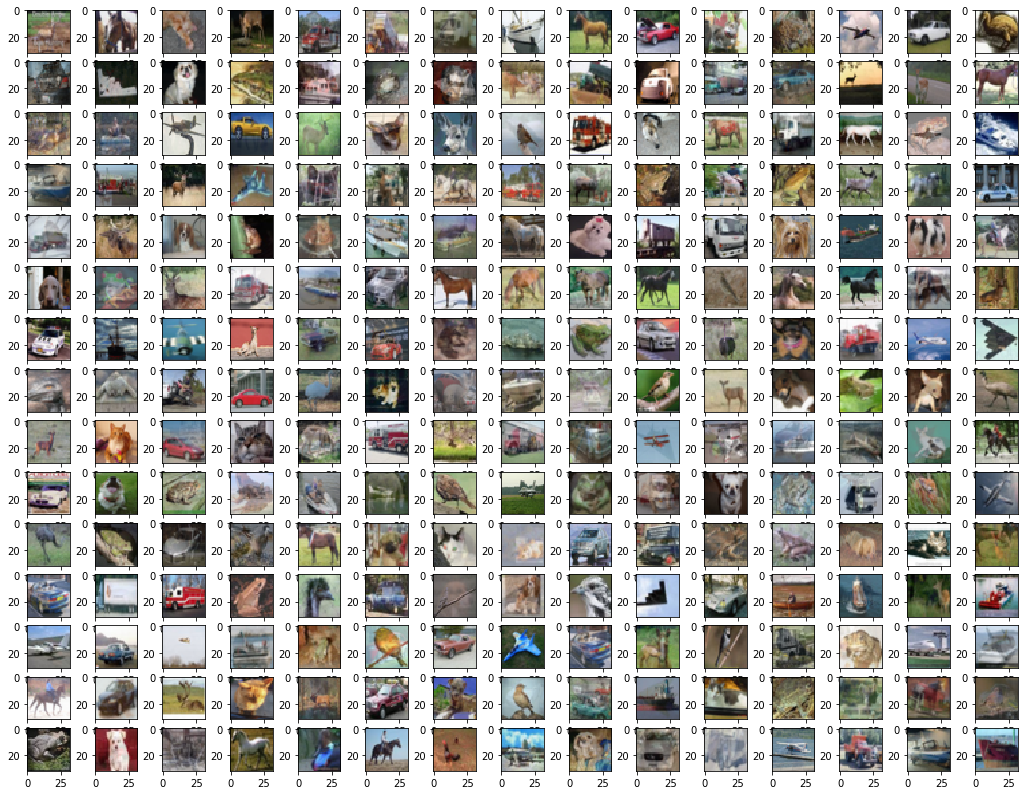

In [17]:
_train_on_batches(cifar_discriminator, cifar_x, cifar_y, 10, 144, mixup=True, alpha=0.5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 128)       1280      
_________________________________________________________________
batch_normalization_7 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 64)          73792     
_________________________________________________________________
batch_normalization_8 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 7, 7, 64)          0         
__________

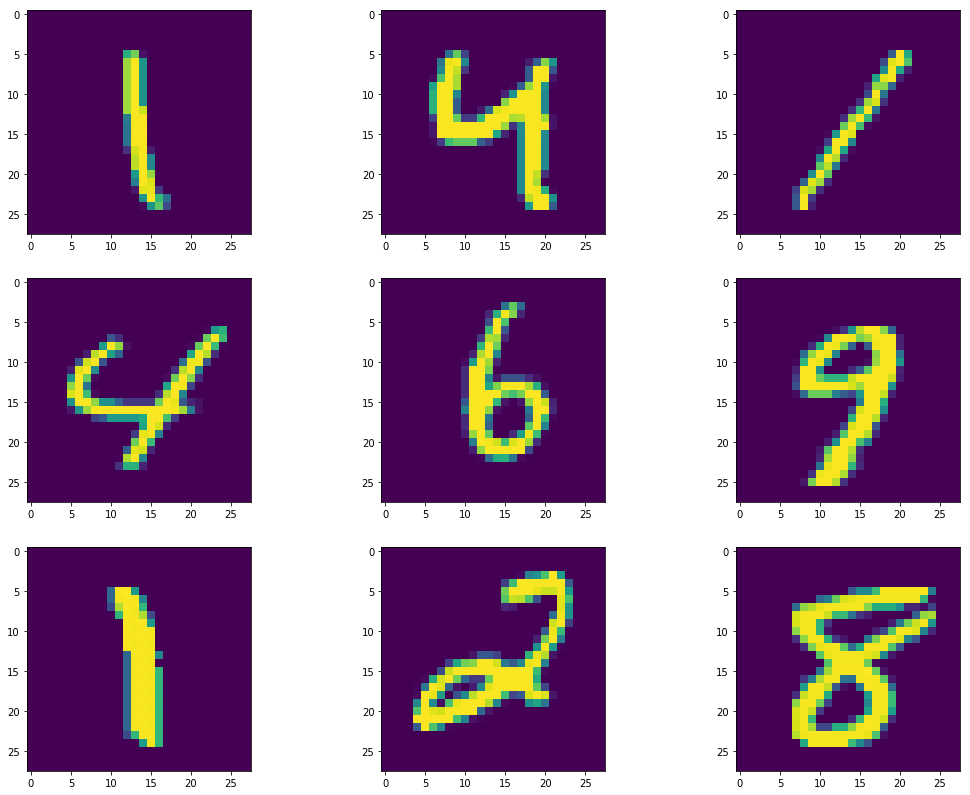

In [18]:
mnist_discriminator = build_discriminative_model((28, 28, 1), 10)
_train_on_batches(mnist_discriminator, mnist_x, mnist_y, 1000, 9, mixup=False, steps_per_print=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 128)       1280      
_________________________________________________________________
batch_normalization_13 (Batc (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 64)          73792     
_________________________________________________________________
batch_normalization_14 (Batc (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 7, 7, 64)          0         
__________

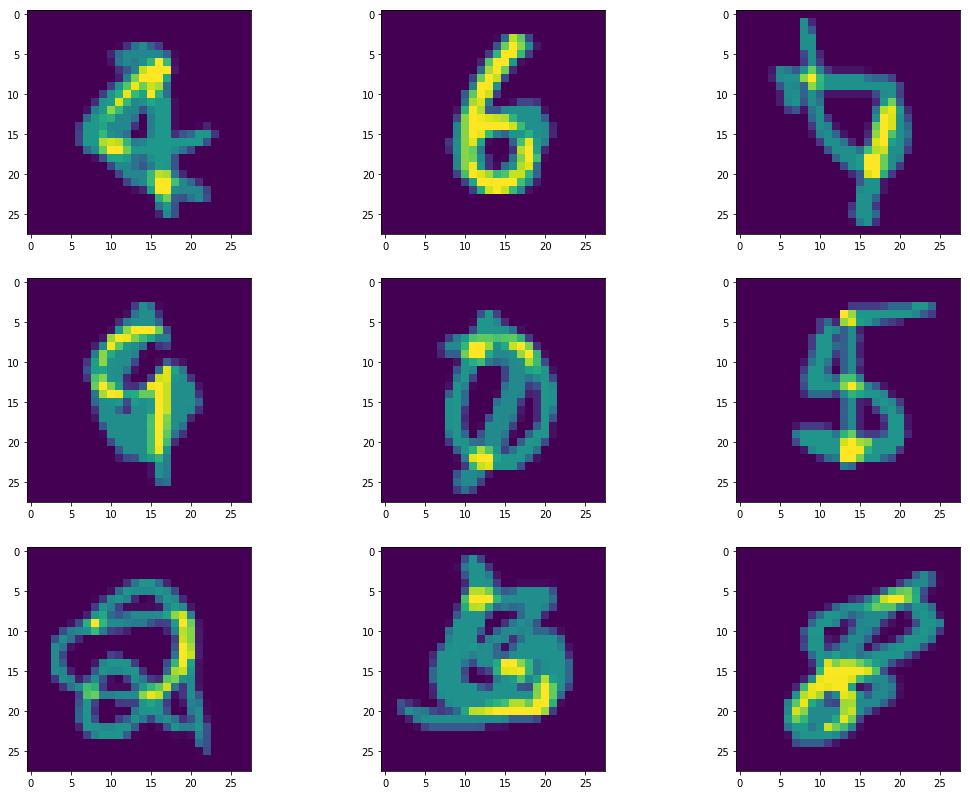

In [20]:
mixup_mnist_model = build_discriminative_model((28, 28, 1), 10)
_train_on_batches(mixup_mnist_model, mnist_x, mnist_y, 10000, 9, mixup=True, alpha=500.0, steps_per_print=1000)

In [25]:
mixup_mnist_model = build_discriminative_model((28, 28, 1), 10)
_train_on_batches(mixup_mnist_model, mnist_x, mnist_y, 10000, 32, mixup=True, steps_per_print=500)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 128)       1280      
_________________________________________________________________
batch_normalization_19 (Batc (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 64)          73792     
_________________________________________________________________
batch_normalization_20 (Batc (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 7, 7, 64)          0         
__________

KeyboardInterrupt: 